# Tensorflow 2.0 

Check Tensorflow installation

In [ ]:
import tensorflow as tf
print(tf.version)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

### Creating Tensor
A tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes.

Creating Scalar (RANK 0 tensor)

In [ ]:
tensor_string = tf.Variable("This is a tensor string", tf.string)
tensor_int = tf.Variable(420, tf.int16)
tensor_float = tf.Variable(69.420, tf.float32)

Creating Vectors/Matrices (RANK >0 tensor)

In [ ]:
rank1_tensor = tf.Variable([69,420], tf.int16)
rank2_tensor = tf.Variable([[49,420],[9,11]], tf.int16)

In [ ]:
tf.rank(rank2_tensor)

In [ ]:
rank2_tensor.shape

Changing shape of a tensor

In [ ]:
tensor1 = tf.ones([2,2,3])
print(tensor1)
tensor2 = tf.reshape(tensor1,[2,3,2])
print(tensor2)
tensor3 = tf.reshape(tensor1,[12])
print(tensor3)

# TensorFlow Core Learning Algorithms

## Linear Regression
Linear regression is one of the most basic forms of machine learning and is used to predict numeric values.

Use when the datapoint is correlated linearly

Example of Data for linear regression

In [ ]:
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])

Line of best fit for this example.

In [ ]:
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

Creating Model to predicting the Line of best fit

Load Dataset

- Titanic dataset contain list and attribute of people boarding Titanic at the time of the crash

In [ ]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [ ]:
dftrain.pop('n_siblings_spouses')
dftrain.pop('fare')
dftrain.head()

In [ ]:
dftrain.describe()

In [ ]:
dftrain.age.hist(bins=20)

In [ ]:
dftrain.sex.value_counts().plot(kind="barh")

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

Encoding categorical and numeric data into tensor

In [ ]:
CATEGORICAL_COLUMNS  = ['sex','parch','class','deck','embark_town','alone']
NUMERICAL_COLUMNS = ['age']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERICAL_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

feature_columns

### Training Process
Load small amount of data (batches) into the model using input function

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=16, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

### Creating a model

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

### Training a model

In [ ]:
linear_est.train(train_input_fn)  # train
#result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data
#clear_output()  # clears consoke output
#print(result)  # the result variable is simply a dict of stats about our model

In [ ]:
result = list(linear_est.predict(eval_input_fn))
correct = 0
incorrect = 0

for i in range(len(result)) :
    print(y_eval.loc[i])
    print(result[i]["probabilities"][1])
    if y_eval.loc[i] == round(result[i]["probabilities"][1]) :
        correct += 1
    else :
        incorrect += 1

accuracy = (correct / (correct + incorrect)) * 100
print("CORRECT PREDICTION : " + str(correct) + '/' + str(correct+incorrect))
print("INCORRECT PREDICTION : " + str(incorrect) + '/' + str(correct+incorrect))
print("ACCURACY : " + str(accuracy) + "%")

## Classification

- Dataset is Iris which is the daataset containing a different species of flower

- load dataset

In [ ]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [ ]:
train.head()

In [ ]:
train_y = train.pop('Species')
test_y = test.pop('Species')

In [ ]:
train_y.head()
train.shape

Creating input function

In [ ]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)


In [ ]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

In [ ]:
my_feature_columns

### Building Model
- DNNClassifier

In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[50, 30],
    # The model must choose between 3 classes.
    n_classes=3)

Training a model

In [ ]:
classifier.train(
    input_fn=lambda: input_fn(train, train_y, training=True),
    steps=5000)
# We include a lambda to avoid creating an inner function previously

Evaluating modeel

In [ ]:
eval_result = classifier.evaluate(
    input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

Predicting using trained model

In [ ]:
input_feature_columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

def usr_input_fn(features, batch_size=256):
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

print("user input")
for feature in input_feature_columns :
    val = input(feature + ' >> ')
    predict[feature] = [float(val)]

print('user input object : ' + str(predict))
predictions = classifier.predict(input_fn=lambda: usr_input_fn(predict))

for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    prob = pred_dict['probabilities'][class_id]
    print('Prediction is "{}" ({:.1f}%)'.format(SPECIES[class_id], 100*prob))


### Hidden Markov Model

finite set of state associated with a probability distribution useful for predicting future event based on past event

States : Could be anything

Observation : Each state will have a particular outcome or observation associated with it

Transitions : Each state will have a probability to transition to a different state

In [ ]:
import tensorflow_probability as tfp
import tensorflow as tf

Example Data : Weather model
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being cold.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is
 normally distributed with mean and standard deviation 0 and 5 on
 a cold day and mean and standard deviation 15 and 10 on a hot day.

In [ ]:
tfd = tfp.distributions
initial_distribution = tfd.Categorical(probs=[0.8, 0.2]) 
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

In [ ]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7) #how many time to step through probability

In [ ]:
mean = model.mean()

with tf.compat.v1.Session() as sess:
    print(mean.numpy())

## Neural Network with Tensorflow

### import

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2023-07-17 09:18:56.582796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 09:18:57.217219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Dataset
MNIST Fashion Dataset
This dataset includes 60,000 images for training and 10,000 images for validation/testing.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

In [3]:
fashion_train_images.shape

(60000, 28, 28)

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

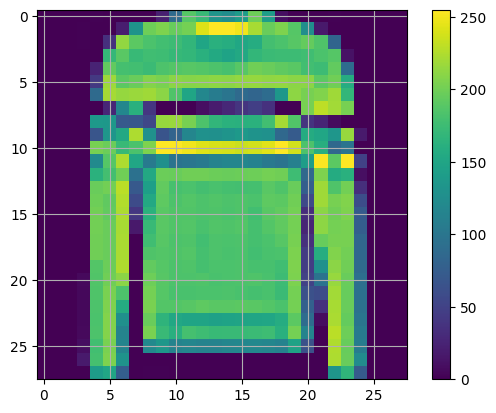

In [5]:
plt.figure()
plt.imshow(fashion_train_images[5])
plt.colorbar()
plt.grid(True)
plt.show()

### Data preprocessing

In [6]:
fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0

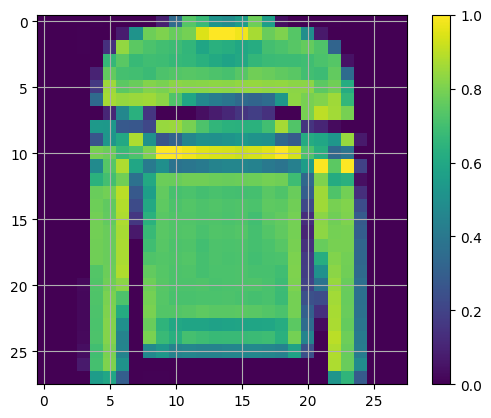

In [7]:
plt.figure()
plt.imshow(fashion_train_images[5])
plt.colorbar()
plt.grid(True)
plt.show()

### Building Model


In [8]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # input layer (1) flatten 28x28 pixel grid to 784 value
    keras.layers.Dense(256, activation='relu'),  # hidden layer (2) 128 Neurons Densly connected using ReLu as activation function
    keras.layers.Dense(10, activation='softmax') # output layer (3) 10 Output nueron for 10 output classes
])

2023-07-17 09:18:59.920309: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-17 09:18:59.936754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-17 09:18:59.936914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Compiling the model

In [9]:
model.compile(optimizer='adam', #performing gradient decent 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### passing or fitting the data to the model 

In [10]:
model.fit(fashion_train_images, fashion_train_labels, epochs=8, batch_size=32)

Epoch 1/8


2023-07-17 09:19:01.739358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-17 09:19:01.740690: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1b0f4ad4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-17 09:19:01.740705: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-17 09:19:01.743707: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-17 09:19:01.854097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-17 09:19:01.954661: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

1875/1875 [==============================] - 5s 2ms/step - loss: 0.4832 - accuracy: 0.8288
Epoch 2/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3626 - accuracy: 0.8680
Epoch 3/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3261 - accuracy: 0.8813
Epoch 4/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3009 - accuracy: 0.8890
Epoch 5/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2867 - accuracy: 0.8930
Epoch 6/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2692 - accuracy: 0.9001
Epoch 7/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2568 - accuracy: 0.9033
Epoch 8/8
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2456 - accuracy: 0.9074


### Evaluating Model

In [11]:
test_loss, test_acc = model.evaluate(fashion_test_images, fashion_test_labels, verbose=1)

print("Test Accuracy : ", test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.3553 - accuracy: 0.8715
Test Accuracy :  0.8715000152587891
